In [1]:
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, DenseNet121, Xception
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomContrast, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
from time import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from scipy.signal import stft
from sklearn.metrics import accuracy_score
import librosa
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder


# Import

In [3]:
data = pd.read_pickle(r"G:\Meu Drive\Scripts\Pos\Aprendizadomaquina\Trabalho_final\data\cwru.pkl")
print(data.shape)
data.head()

(161, 9)


,fault_type,fault_location,fault_size,load,label,12K,DE,FE,BA
0,ball,DE,7,0,3,True,"[-0.0027613972055888225, -0.09632403193612774,...","[-0.24716181818181818, 0.14279090909090908, 0....","[0.015531632047477748, 0.016939940652818994, -..."
1,ball,DE,7,1,3,True,"[-0.07212119760479042, 0.30310395209580837, 0....","[0.07745636363636363, 0.045610909090909084, -0...","[0.07327228486646885, 0.06932902077151336, 0.0..."
2,ball,DE,7,2,3,True,"[-0.3144744111776447, 0.12198878243512974, 0.3...","[0.1479272727272727, -0.044994545454545454, 0....","[-0.01126646884272997, 0.02265364985163205, 0...."
3,ball,DE,7,3,3,True,"[0.09031393213572854, 0.22497265469061875, -0....","[0.07232, -0.007807272727272727, 0.12327272727...","[-0.05460213649851632, -0.05778089020771514, -..."
4,ball,DE,14,0,0,True,"[-0.46781317365269465, 0.1790035129740519, 0.4...","[0.09697454545454545, 0.27058363636363636, 0.1...","[0.0016497329376854602, 0.08047477744807123, 0..."


In [4]:
 # Defining labels
labels = pd.Series([data['fault_type'][i] + '-' + str(data['fault_size'][i])
                    for i in range(len(data))])
classes = sorted(labels.unique())
classes

['ball-14',
 'ball-21',
 'ball-28',
 'ball-7',
 'inner-14',
 'inner-21',
 'inner-28',
 'inner-7',
 'normal-0',
 'outer-14',
 'outer-21',
 'outer-7']

# Analise exploratoria

## Separando uma amostra de cada classe para os plots

In [5]:
to_plot = data[(data['fault_location'] == 'DE') &
          (data['load'] == '3')
          | (data['fault_location'] == 'normal') &
          (data['load'] == '3')]

# to_plot = to_plot[to_plot['12K'] == True]

to_plot = to_plot.drop_duplicates(subset=['fault_type', 'fault_size'], keep='first')

to_plot

,fault_type,fault_location,fault_size,load,label,12K,DE,FE,BA
3,ball,DE,7,3,3,True,"[0.09031393213572854, 0.22497265469061875, -0....","[0.07232, -0.007807272727272727, 0.12327272727...","[-0.05460213649851632, -0.05778089020771514, -..."
7,ball,DE,14,3,0,True,"[0.1054203992015968, -0.10736962075848304, -0....","[0.20463272727272727, 0.24839454545454545, 0.0...","[0.0493712759643917, 0.06248866468842731, 0.04..."
11,ball,DE,21,3,1,True,"[0.07244606786427145, 0.04791836327345309, -0....","[0.11977999999999998, 0.15059818181818183, 0.0...","[-0.07295038575667656, -0.09145958456973295, -..."
15,ball,DE,28,3,2,True,"[-6.5584142, 4.0616758, 7.613099, -2.2330672, ...",None,None
19,inner,DE,7,3,7,True,"[0.2226985628742515, 0.09323776447105789, -0.1...","[-0.09738545454545454, -0.1808, -0.23360181818...","[0.07741673590504453, -0.0024142433234421367, ..."
23,inner,DE,14,3,4,True,"[-0.009908542914171658, 0.06919736526946108, -...","[-0.028558181818181816, -0.11895818181818181, ...","[0.055447121661721076, -0.009133887240356084, ..."
27,inner,DE,21,3,5,True,"[-0.2062926147704591, -0.007309580838323354, 0...","[-0.21264545454545453, -0.12265636363636362, 0...","[-0.06502362017804154, -0.04796296735905045, -..."
31,inner,DE,28,3,6,True,"[-0.9338355, -0.5749497, 0.3812653, 1.1918101,...",None,None
35,outer,DE,7,3,11,True,"[0.16438435129740517, 0.2150641117764471, -0.2...","[-0.08752363636363636, 0.40659454545454543, -0...","[0.002092344213649852, 0.0009656973293768547, ..."
47,outer,DE,14,3,9,True,"[-0.15443784431137725, 0.02866275449101796, -0...","[0.03800909090909091, -0.035954545454545454, 0...","[0.005834421364985164, -0.011427418397626114, ..."


## Plots

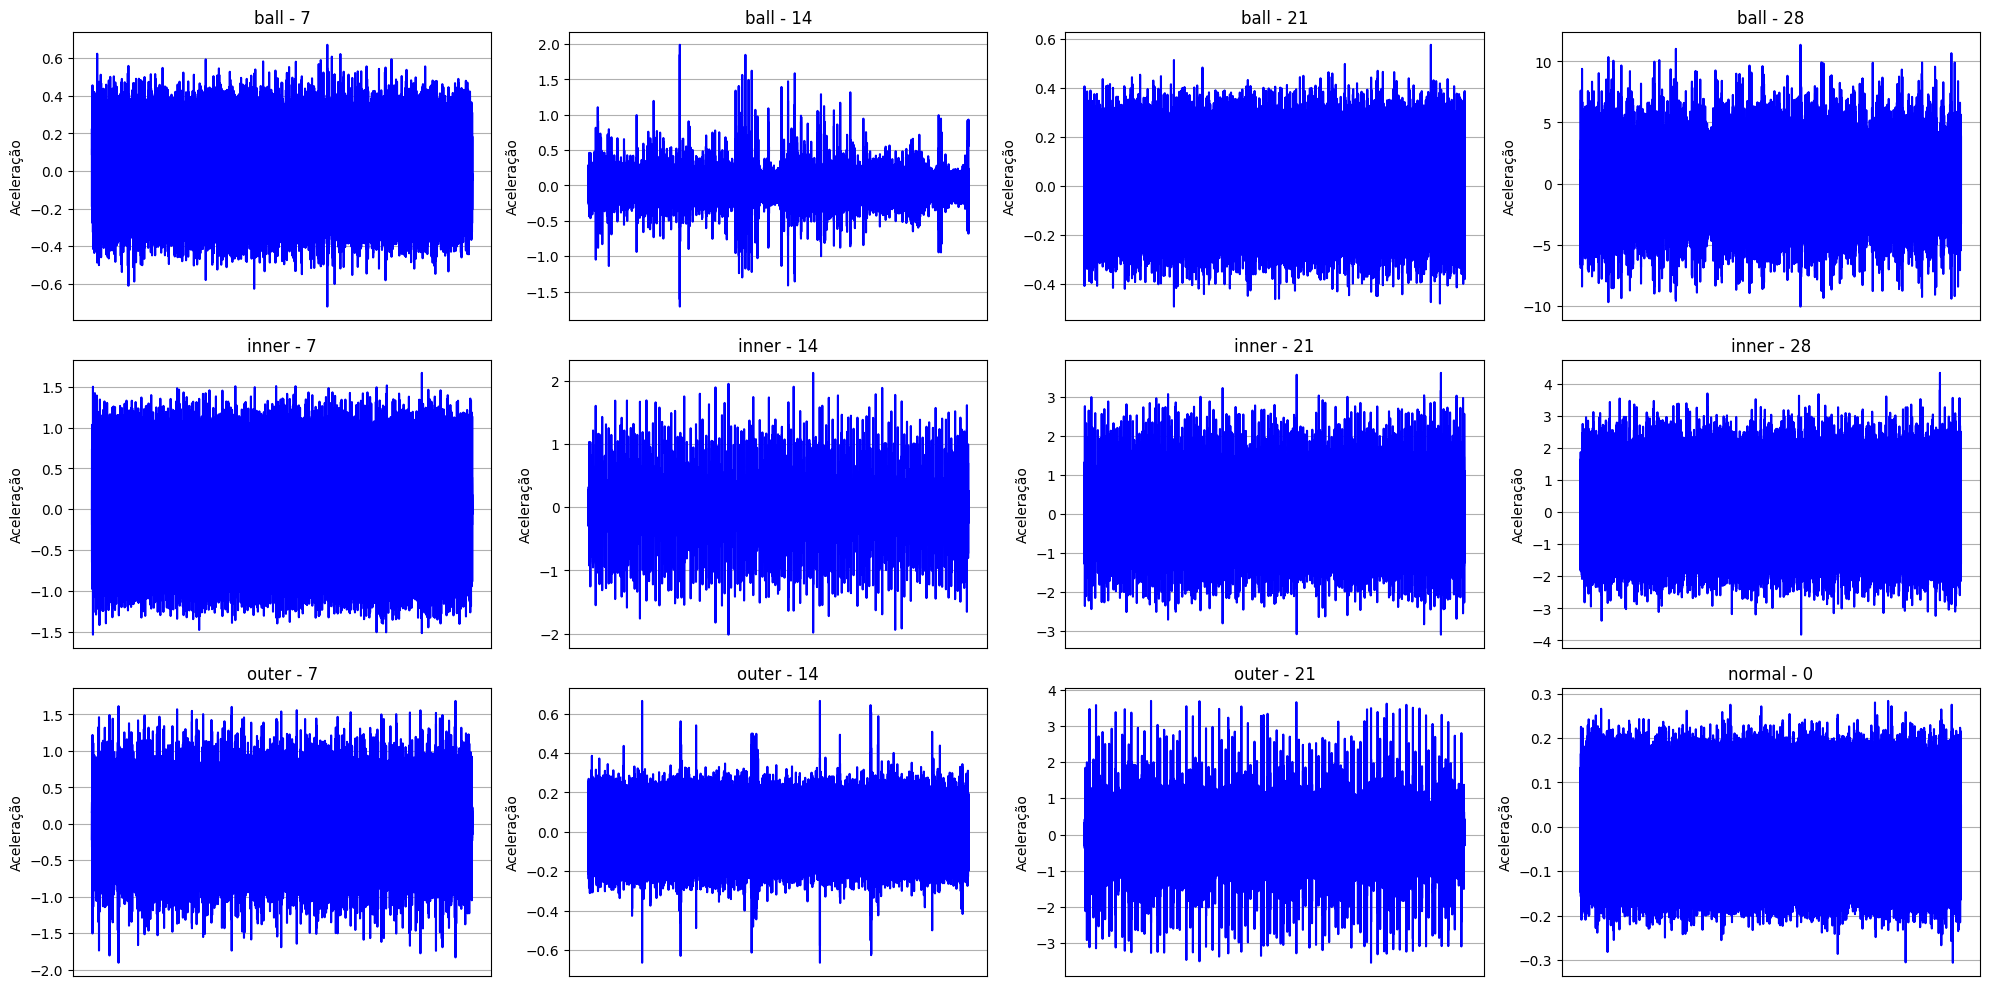

In [6]:
to_plot = to_plot.reset_index(drop=True)

# Definindo o tamanho da figura e a grade de subplots (3 linhas x 4 colunas)
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Iterar sobre cada linha do DataFrame e cada eixo do subplot
for index, row in to_plot.iterrows():
    lista = row['DE']
    titulo = f"{row['fault_type']} - {row['fault_size']}"

    # Encontrar a posição do subplot
    ax = axes[index // 4, index % 4]  # Divisão inteira para linha e módulo para coluna
    # Plotar a lista no gráfico
    ax.plot(lista, color='b')
    ax.set_title(titulo)
    # ax.set_xlabel('Índice')
    ax.set_xticks([])
    ax.set_ylabel('Aceleração')
    ax.grid(True)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

## Função para downsample

Artigo aplica um downsample para uma amostragem de 6kHz

In [7]:
def downsample(df, f_sample = 12e3):
  df_final = pd.DataFrame(columns = ['data', 'label'])
  for index, row in df.iterrows():
    sr_12k = 12e3  # Taxa de amostragem se 'coluna_boolean' for True
    sr_48k = 48e3  # Taxa de amostragem se 'coluna_boolean' for False

    DE = row['DE'] #Identificar dados DE
    FE = row['FE'] #Identificar dados FE
    BA = row['BA'] #Identificar dados BA

    sr_original = sr_12k if row['12K'] else sr_48k

    data = []

    if DE is not None:
      DE = np.array(row['DE'])
      data.append(DE)

    if FE is not None:
      FE = np.array(row['FE'])
      data.append(FE)

    if BA is not None:
      BA = np.array(row['BA'])
      data.append(BA)

    data_downsampled = []
    for sinal in data:
      # print(sinal)
      sinal = np.array(sinal)
      down_sample = librosa.resample(sinal, orig_sr=sr_original, target_sr=f_sample)

      data_downsampled.append(down_sample)

    df_temp = pd.DataFrame(data_downsampled)

    df_temp = df_temp.apply(lambda row: np.array(row[~np.isnan(row)] ,dtype = float), axis=1)

    df_temp = df_temp.to_frame(name='data')

    df_temp['label'] = row['label']

    df_final = pd.concat([df_final, df_temp])

  df_final = df_final.reset_index(drop=True)
  return df_final


df_downsampled = downsample(to_plot)
df_downsampled.head()

,data,label
0,"[0.09031393213572854, 0.22497265469061875, -0....",3
1,"[0.07232, -0.007807272727272727, 0.12327272727...",3
2,"[-0.05460213649851632, -0.05778089020771514, -...",3
3,"[0.1054203992015968, -0.10736962075848304, -0....",0
4,"[0.20463272727272727, 0.24839454545454545, 0.0...",0


## Segmentação


Além da mudança na amostragem é feito uma segmentação com tamanho de 1600 pontos

In [8]:
def segment_signal(signal, window_size, overlap=0):
    """
    Segmenta um sinal em janelas de tamanho fixo, com uma sobreposição opcional.

    Parâmetros:
        signal (array-like): O sinal a ser segmentado (lista ou numpy array).
        window_size (int): O tamanho de cada segmento (janela).
        overlap (int, opcional): O número de amostras que devem sobrepor entre janelas.
                                 Por padrão é 0 (sem sobreposição).

    Retorno:
        list: Uma lista contendo as janelas segmentadas do sinal.
    """
    if window_size <= 0:
        raise ValueError("O tamanho da janela deve ser maior que zero.")
    if overlap >= window_size:
        raise ValueError("A sobreposição deve ser menor que o tamanho da janela.")

    step = window_size - overlap
    segments = [signal[i:i + window_size] for i in range(0, len(signal) - window_size + 1, step)]

    return segments

In [9]:
def segmentação(df, tamanho_segmento = 1600):
  df_final = pd.DataFrame(columns = ['data', 'label'])
  for index, row in df.iterrows():
    data = row['data']
    label = row['label']



    segmentos = segment_signal(data,tamanho_segmento,tamanho_segmento//2)

    for segmento in segmentos:

      df_temp = pd.DataFrame({'data': [segmento], 'label': [label]})
      df_final = pd.concat([df_final, df_temp])

  df_final = df_final.reset_index(drop=True)

  return df_final

df_segmentado = segmentação(df_downsampled)
df_segmentado.head()


,data,label
0,"[0.09031393213572854, 0.22497265469061875, -0....",3
1,"[-0.007959321357285429, -0.17429289421157684, ...",3
2,"[-0.1780289021956088, -0.1954094610778443, 0.1...",3
3,"[-0.043045309381237525, 0.28036303393213574, 0...",3
4,"[0.21993716566866267, -0.049380279441117766, -...",3


## STFT

In [10]:
def get_stft(df, janela = 128, passo = 32):
  df_final = pd.DataFrame(columns = ['stft', 'label'])
  for index, row in df.iterrows():
    data = row['data']
    label = row['label']
    noverlap = janela - passo

    # Aplicar a transformada STFT
    f, t, stft_result = stft(np.array(data),fs = 12000 ,nperseg = janela, noverlap = noverlap)

    df_temp = pd.DataFrame({'stft': [np.delete(np.abs(stft_result),-1,1)], 'label': [label]})

    df_final = pd.concat([df_final, df_temp])

  df_final = df_final.reset_index(drop=True)

  return df_final

df_stft = get_stft(df_segmentado)
df_stft.head()


,stft,label
0,"[[0.0046627964379330165, 0.004969686013366023,...",3
1,"[[0.0036535953150725136, 0.00220930525729235, ...",3
2,"[[0.003896214181431377, 0.002196604235786035, ...",3
3,"[[0.0027944988184996147, 0.005684842785698682,...",3
4,"[[0.009487218032625885, 0.004989715404617692, ...",3


In [11]:
df_stft["label"].value_counts()

label
7     456
0     453
1     453
4     453
5     453
11    453
9     453
10    453
3     450
8     300
2     150
6     150
Name: count, dtype: int64

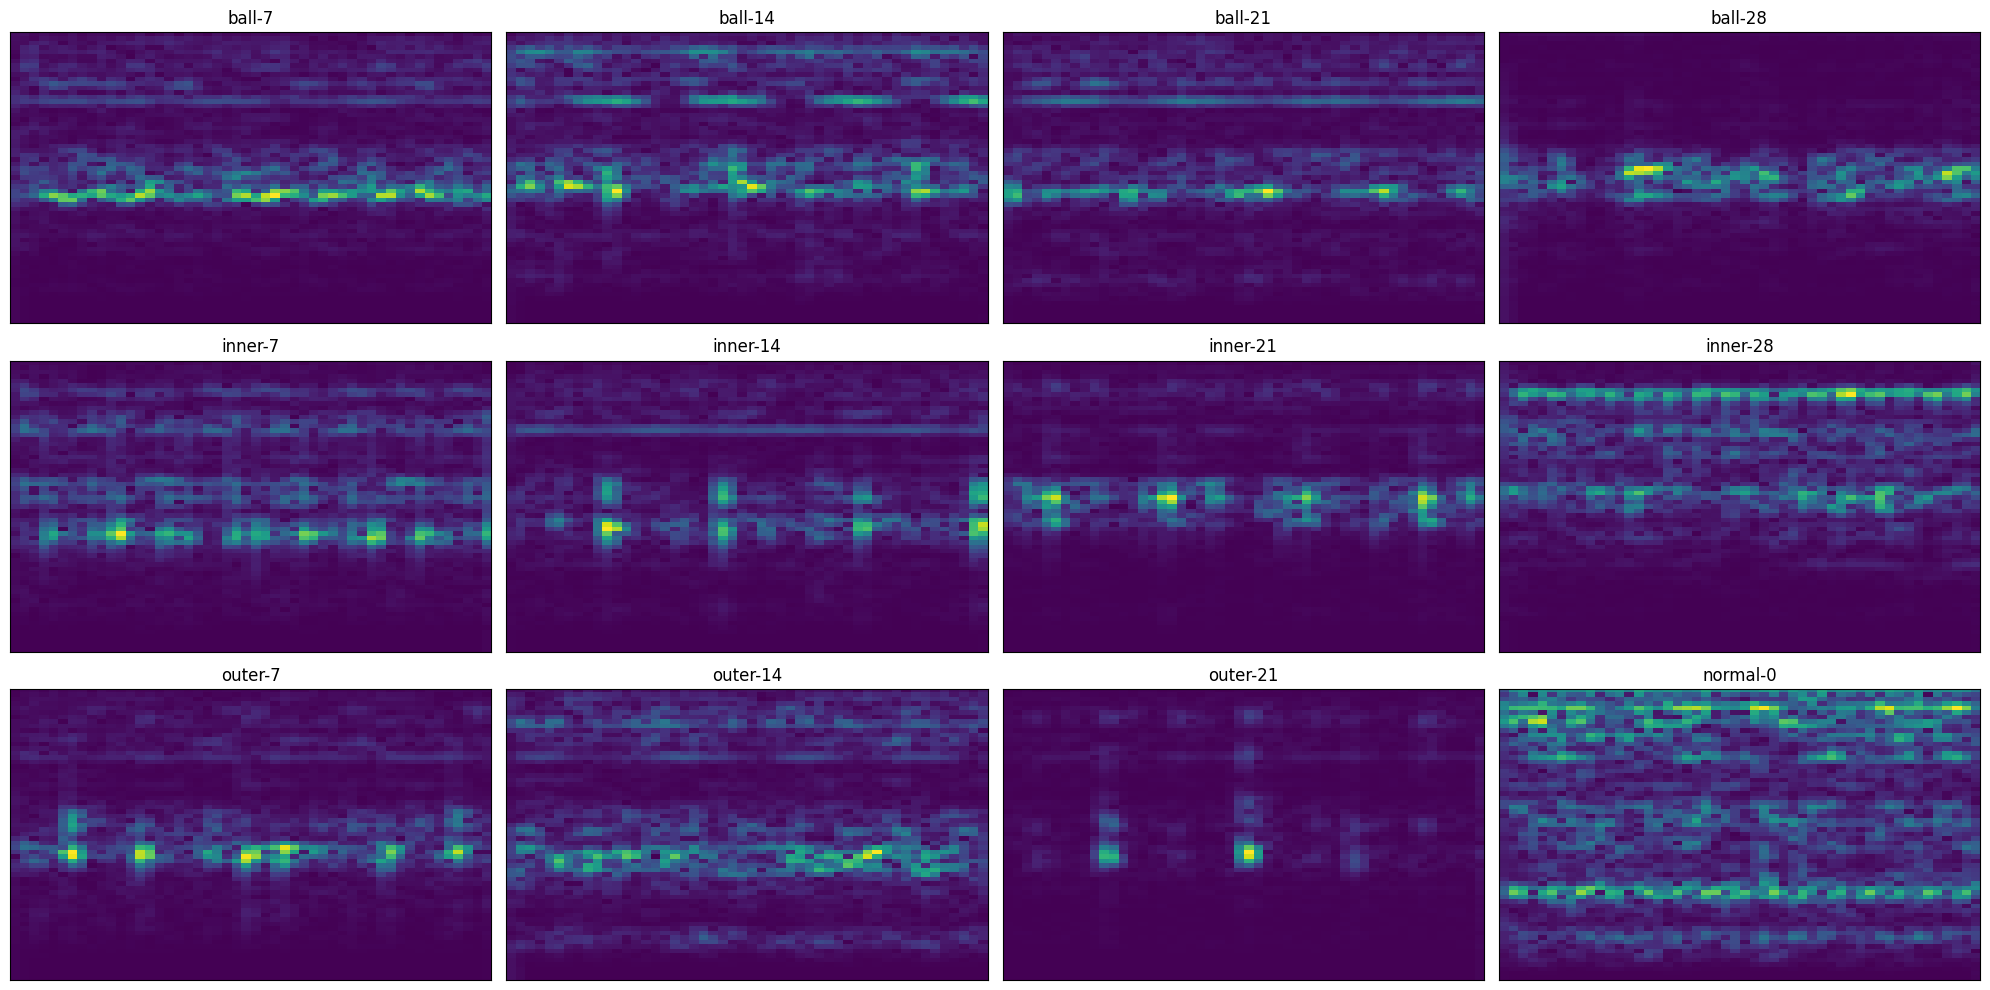

In [12]:
to_plot = df_stft.drop_duplicates(subset=['label'], keep='first')

to_plot = to_plot.reset_index(drop=True)

# Definindo o tamanho da figura e a grade de subplots (3 linhas x 4 colunas)
fig, axes = plt.subplots(3, 4, figsize=(20, 10))

# Iterar sobre cada linha do DataFrame e cada eixo do subplot
for index, row in to_plot.iterrows():
    matriz = row['stft']
    titulo = f"{classes[int(row['label'])]}"

    # Encontrar a posição do subplot
    ax = axes[index // 4, index % 4]  # Divisão inteira para linha e módulo para coluna

    # Plotar a matriz 2D usando imshow
    cax = ax.imshow(np.abs(matriz), cmap='viridis', aspect='auto')
    ax.set_title(titulo)
    ax.set_xticks([])
    ax.set_yticks([])

    # Adicionar uma barra de cor para cada subplot
    # fig.colorbar(cax, ax=ax)

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

In [13]:
df_stft[df_stft['label'] == 8]['stft'].iloc[0].shape

(65, 50)

In [14]:
df_stft[df_stft['label'] == 0]['stft'].iloc[0].shape

(65, 50)

# Preparação dos dados

In [15]:
# prompt: Gere um codigo que olhe para a df dados e verifique se a fault_location é DE caso seja vai pegar o sinal da coluna FE concatenar no fim da df com as outras colunas com o mesmo valor, mudando o fault_type e fault_location para normal e o label para 8

def process_de_fault(df):
  """
  Processes rows where 'fault_location' is 'DE'.

  For rows with 'fault_location' as 'DE', it concatenates the 'FE' signal
  to the end of the DataFrame, modifies other columns, and returns the new DataFrame.
  """
  new_rows = []
  for index, row in df.iterrows():
    if row['fault_location'] == 'DE':
      if row['FE'] is not None:  # Check if 'FE' column has a value
        new_row = row.copy()
        new_row['DE'] = None # Concatenate FE signal to data
        row['FE'] = None
        new_row['fault_type'] = 'normal'
        new_row['fault_location'] = 'normal'
        new_row['label'] = 8
        new_rows.append(row)
        new_rows.append(new_row)
      else:
        new_rows.append(row)
    else:
      new_rows.append(row)
  return pd.DataFrame(new_rows)

In [16]:
dados = data[(data['fault_location'] == 'DE') | (data['fault_location'] == 'normal') ]
dados = df_processed = process_de_fault(dados)
# dados.loc[(data['fault_location'] == 'DE'), 'FE'] = None
dados.loc[(data['fault_location'] == 'DE'), 'BA'] = None
dados

,fault_type,fault_location,fault_size,load,label,12K,DE,FE,BA
0,ball,DE,7,0,3,True,"[-0.0027613972055888225, -0.09632403193612774,...",None,None
0,normal,normal,7,0,8,True,None,"[-0.24716181818181818, 0.14279090909090908, 0....",None
1,ball,DE,7,1,3,True,"[-0.07212119760479042, 0.30310395209580837, 0....",None,None
1,normal,normal,7,1,8,True,None,"[0.07745636363636363, 0.045610909090909084, -0...",None
2,ball,DE,7,2,3,True,"[-0.3144744111776447, 0.12198878243512974, 0.3...",None,None
...,...,...,...,...,...,...,...,...,...
156,normal,normal,21,3,8,False,None,"[0.10028646464646465, 0.04356707070707071, -0....",None
157,normal,normal,0,3,8,False,"[0.014603076923076923, 0.05444861538461539, 0....","[0.19292181818181817, 0.16436363636363635, 0.0...",None
158,normal,normal,0,0,8,False,"[0.05319692307692307, 0.08866153846153846, 0.0...","[0.14566727272727273, 0.09779636363636364, 0.0...",None
159,normal,normal,0,1,8,False,"[0.046104, -0.03713353846153846, -0.0894959999...","[0.023216363636363632, 0.08115454545454545, 0....",None


In [17]:
dados['label'].value_counts()

label
8     108
11     24
10     24
3       8
0       8
1       8
7       8
4       8
5       8
9       8
2       4
6       4
Name: count, dtype: int64

In [18]:
dados['fault_location'].value_counts()

fault_location
DE        112
normal    108
Name: count, dtype: int64

In [19]:
df_downsampled = downsample(dados)
df_segmentacao = segmentação(df_downsampled)
df = get_stft(df_segmentacao)
df.head()

,stft,label
0,"[[0.01157540145002548, 0.01762599445935281, 0....",3
1,"[[0.004265486339463177, 0.015360822443847151, ...",3
2,"[[0.0010559130214167268, 0.011062785048560776,...",3
3,"[[0.009037516468552796, 0.013847087892614705, ...",3
4,"[[0.006196306520358481, 0.01356841395415791, 0...",3


In [20]:
df.iloc[0]['stft'].shape

(65, 50)

In [21]:
df.shape

(31182, 2)

In [22]:
df['label'].value_counts()

label
8     15516
10     3325
11     3315
0      1132
1      1132
5      1131
9      1131
3      1130
7      1129
4      1041
2       600
6       600
Name: count, dtype: int64

In [23]:
df.to_pickle(r"G:\Meu Drive\Scripts\Pos\Aprendizadomaquina\Trabalho_final\data\stft.pkl")

In [2]:
df = pd.read_pickle(r"G:\Meu Drive\Scripts\Pos\Aprendizadomaquina\Trabalho_final\data\stft.pkl")

# Separação dos dados

In [3]:
def sample_labels_exact(df, label_col, n_samples):
    """
    Mantém exatamente `n_samples` amostras para cada valor na coluna `label_col`.

    Parâmetros:
        df (pd.DataFrame): O DataFrame original.
        label_col (str): O nome da coluna de rótulos (labels).
        n_samples (int): O número de amostras a manter para cada label.

    Retorno:
        pd.DataFrame: Um novo DataFrame com as amostras selecionadas.
    """
    sampled_df = (
        df.groupby(label_col, group_keys=False)
          .apply(lambda x: x.sample(n=n_samples, random_state=42))
    )
    return sampled_df.reset_index(drop=True)


In [4]:
def prepare_data(series):
    """
    Prepara uma série contendo arrays 2D para entrada em um modelo.

    Args:
        series (pd.Series): Série com arrays 2D do NumPy.

    Returns:
        np.ndarray: Array 4D pronto para ser usado como entrada do modelo.
    """
    # Verificar a consistência das dimensões
    shapes = series.apply(lambda x: x.shape)
    if not all(shape == shapes.iloc[0] for shape in shapes):
        raise ValueError("Todos os arrays devem ter dimensões consistentes.")

    # Expandir a dimensão para incluir o canal (1 para escala de cinza)
    arrays = series.apply(lambda x: np.expand_dims(x, axis=-1)).values

    # Consolidar em um único array 4D
    data = np.stack(arrays, axis=0)

    # Normalizar os valores (ajuste conforme necessário para seu modelo)
    # data = data / 255.0  # Normalizando para [0, 1]

    return data

In [5]:
df_sampled = sample_labels_exact(df, 'label', 600)
df_sampled['label'].value_counts()

C:\Users\Luiz\AppData\Local\Temp\ipykernel_15392\3058520353.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(label_col, group_keys=False)


label
0     600
1     600
2     600
3     600
4     600
5     600
6     600
7     600
8     600
9     600
10    600
11    600
Name: count, dtype: int64

In [6]:
df_train, df_test = train_test_split(df_sampled,train_size=0.5,stratify=df_sampled['label'], random_state= 42)
df_val, df_test = train_test_split(df_test, train_size = 1/3, stratify=df_test['label'], random_state= 42)



X_train = prepare_data(df_train['stft'])
y_train = to_categorical(df_train['label'], num_classes=12)
df_train['label'].value_counts()

label
4     300
3     300
9     300
1     300
8     300
2     300
5     300
7     300
11    300
10    300
0     300
6     300
Name: count, dtype: int64

In [7]:
X_val = prepare_data(df_val['stft'])
y_val = to_categorical(df_val['label'], num_classes=12)
df_val['label'].value_counts()

label
6     100
11    100
2     100
3     100
7     100
10    100
0     100
9     100
4     100
8     100
5     100
1     100
Name: count, dtype: int64

In [8]:
X_test = prepare_data(df_test['stft'])
y_test = to_categorical(df_test['label'], num_classes=12)
df_test['label'].value_counts()

label
11    200
9     200
6     200
4     200
5     200
3     200
2     200
7     200
10    200
1     200
0     200
8     200
Name: count, dtype: int64

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3600, 65, 50, 1)
(1200, 65, 50, 1)
(2400, 65, 50, 1)
(3600, 12)
(1200, 12)
(2400, 12)


In [30]:
X_train = X_train/np.max(X_train)
X_val = X_val/np.max(X_train)
X_test = X_test/np.max(X_train)

In [31]:
# # prompt: Pegue o X_train que possui 3600 espcrtogramas, e plote 10 aleatorios em um grid 2x5

# import random

# # Seleciona 10 índices aleatórios
# indices_aleatorios = random.sample(range(X_train.shape[0]), 10)

# # Cria uma figura com uma grade 2x5
# fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# # Itera sobre os índices aleatórios e plota os espectrogramas
# for i, index in enumerate(indices_aleatorios):
#     row = i // 5
#     col = i % 5

#     # Get the label (convert from categorical to integer)
#     label = classes[np.argmax(y_train[index])]

#     axes[row, col].imshow(X_train[index, :, :, 0], cmap='viridis', aspect='auto')
#     axes[row, col].set_title(f"Label: {label}")  # Include label in title
#     axes[row, col].axis('off')

# plt.tight_layout()
# plt.show()

# Montar modelos

In [32]:
def get_CNN3():
    CNN3 = Sequential([
        Input((65,50,1)),
        Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
        Conv2D(64, (1, 1), activation='relu',strides= 1, padding = 'same'),
        Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
        Conv2D(64, (1, 1), activation='relu',strides= 1, padding = 'same'),
        Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
        Conv2D(64, (1,1), activation='relu',strides= 1, padding = 'same'),
        Conv2D(1, (1,1), activation='relu',strides= 1, padding = 'same'),
        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(12, activation='softmax')

    ])
    return CNN3

CNN3 = get_CNN3()

@tf.function
def model_fn(input_tensor):
    return CNN3(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

CNN3.summary()

FLOPS totais: 0.2846 (G)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 65, 50, 32)        320       
                                                                 
 conv2d_121 (Conv2D)         (None, 65, 50, 64)        2112      
                                                                 
 conv2d_122 (Conv2D)         (None, 65, 50, 32)        18464     
                                                                 
 conv2d_123 (Conv2D)         (None, 65, 50, 64)        2112      
                                                                 
 conv2d_124 (Conv2D)         (None, 65, 50, 32)        18464     
                                                                 
 conv2d_125 (Conv2D)         (None, 65, 50, 64)        2112      
                                                                 
 conv2d_126 (Conv2D)        

In [33]:
def get_CNN2():
    CNN2 = Sequential([
        Input((65,50,1)),
        Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
        Conv2D(64, (1, 1), activation='relu',strides= 1, padding = 'same'),
        Conv2D(32, (3, 3), activation='relu',strides= 1, padding = 'same'),
        Conv2D(64, (1,1), activation='relu',strides= 1, padding = 'same'),
        Conv2D(1, (1,1), activation='relu',strides= 1, padding = 'same'),
        Flatten(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(12, activation='softmax')

    ])
    return CNN2

CNN2 = get_CNN2()

@tf.function
def model_fn(input_tensor):
    return CNN2(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

CNN2.summary()

FLOPS totais: 0.1511 (G)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_127 (Conv2D)         (None, 65, 50, 32)        320       
                                                                 
 conv2d_128 (Conv2D)         (None, 65, 50, 64)        2112      
                                                                 
 conv2d_129 (Conv2D)         (None, 65, 50, 32)        18464     
                                                                 
 conv2d_130 (Conv2D)         (None, 65, 50, 64)        2112      
                                                                 
 conv2d_131 (Conv2D)         (None, 65, 50, 1)         65        
                                                                 
 flatten_33 (Flatten)        (None, 3250)              0         
                                                                 
 dense_107 (Dense)          

In [34]:
def get_liteCNN():
    liteCNN = Sequential([
    Input((65,50, 1)),
    Conv2D(32, (3, 3), activation='relu', strides= 1, padding = 'same' ),
    Conv2D(64, (1, 1), activation='relu', strides= 1, padding = 'same' ),
    Conv2D(1, (1, 1), activation='relu', strides= 1, padding = 'same' ),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
    ])
    
    return liteCNN

liteCNN = get_liteCNN()

@tf.function
def model_fn(input_tensor):
    return liteCNN(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

liteCNN.summary()

FLOPS totais: 0.0177 (G)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_132 (Conv2D)         (None, 65, 50, 32)        320       
                                                                 
 conv2d_133 (Conv2D)         (None, 65, 50, 64)        2112      
                                                                 
 conv2d_134 (Conv2D)         (None, 65, 50, 1)         65        
                                                                 
 flatten_34 (Flatten)        (None, 3250)              0         
                                                                 
 dense_110 (Dense)           (None, 256)               832256    
                                                                 
 dropout_68 (Dropout)        (None, 256)               0         
                                                                 
 dense_111 (Dense)          

In [35]:
def get_CNN0():
    CNN0 = Sequential([
    Input((65,50,1)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])
    
    return CNN0

CNN0 = get_CNN0()

@tf.function
def model_fn(input_tensor):
    return CNN0(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")

CNN0.summary()

FLOPS totais: 0.0018 (G)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_35 (Flatten)        (None, 3250)              0         
                                                                 
 dense_113 (Dense)           (None, 256)               832256    
                                                                 
 dropout_70 (Dropout)        (None, 256)               0         
                                                                 
 dense_114 (Dense)           (None, 256)               65792     
                                                                 
 dropout_71 (Dropout)        (None, 256)               0         
                                                                 
 dense_115 (Dense)           (None, 12)                3084      
                                                                 
Total params: 901,132
Traina

In [36]:
def get_ResNet():
    input_shape = (65, 50, 1)


# 1. Create the ResNet50 base model
    base_model = ResNet50(weights=None, include_top=False, input_shape=input_shape)

# 2. Add Global Average Pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

# 3. Add a fully connected layer
# x = Dense(1000, activation='relu')(x)
    x = Dense(12, activation='softmax')(x)  # Assuming 12 output classes

    ResNet = Model(inputs=base_model.input, outputs=x)
    return ResNet

ResNet = get_ResNet()

@tf.function
def model_fn(input_tensor):
    return ResNet(input_tensor)


input_shape = (1, 65, 50, 1)  # Exemplo de entrada
dummy_input = tf.random.normal(input_shape)

concrete_function = model_fn.get_concrete_function(dummy_input)
options = ProfileOptionBuilder.float_operation()  # Opção para calcular FLOPS
profile_info = profile(concrete_function.graph, options=options)
flops = profile_info.total_float_ops
print(f"FLOPS totais: {flops*1e-9:.4f} (G)")


FLOPS totais: 0.7156 (G)


# Treinamento preliminar

In [ ]:
models = [
    get_CNN3(),
    get_CNN2(),
    get_liteCNN(),
    get_CNN0(),
    get_ResNet()
    ]

names = [
    'CNN3',
    'CNN2',
    'liteCNN',
    'CNN0',
    'ResNet'
    ]

: 

In [37]:
def plots(history, xlim=None, ylim=None, name = None):
  if hasattr(history, 'history'):
    history = history.history
  plt.figure(figsize=(14, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['loss'], '.-', label='Train loss')
  if 'val_loss' in history.keys():
    plt.plot(history['val_loss'], '.-', label='Val loss')
  plt.xlabel('Epochs');
  plt.legend();
  plt.yscale('log')
  plt.grid(which='both');
  plt.subplot(1, 2, 2)
  plt.plot(history['accuracy'], '.-', label='Train accuracy')
  plt.xlabel('Epochs');
  if 'val_accuracy' in history.keys():
    plt.plot(history['val_accuracy'], '.-', label='Val accuracy')
    plt.title(f"Val accuracy: {np.max(history['val_accuracy']):.1%} (best) | {history['val_accuracy'][-1]:.1%} (last)");
  plt.legend();
  plt.xlim(xlim);
  plt.ylim(ylim);
  if name is not None:
    plt.title(name)
  plt.grid();
  # plt.show();

In [21]:
def train(model, epochs, batch_size, lr, callbacks):
  from tqdm.keras import TqdmCallback
  callbacks = callbacks + [TqdmCallback(verbose=0)]
  # Change loss function to 'categorical_crossentropy'
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=lr))
  history = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0, callbacks=callbacks, epochs=epochs)
  return history

In [22]:
from tensorflow.keras.callbacks import EarlyStopping

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/100 [00:00<?, ?epoch/s]

 11%|█         | 11/100 [00:30<04:03,  2.73s/epoch, loss=0.208, accuracy=0.936, val_loss=8.22, val_accuracy=0.0833]


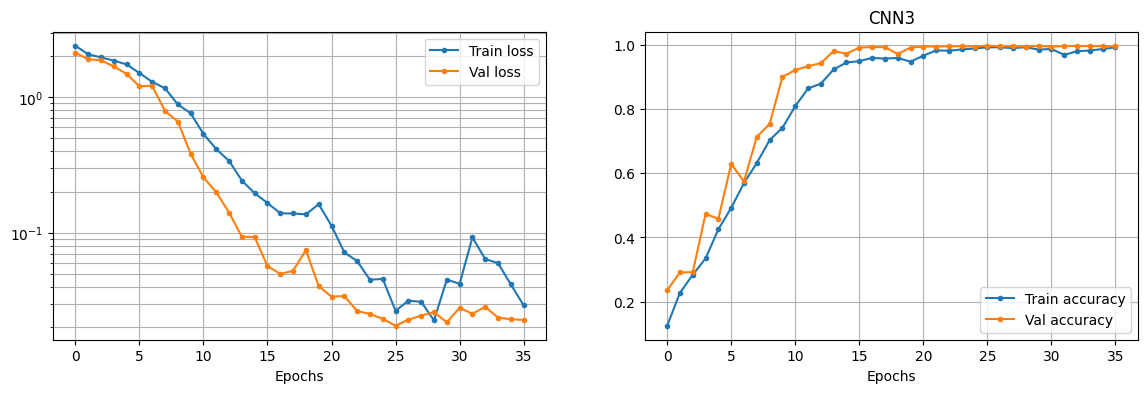

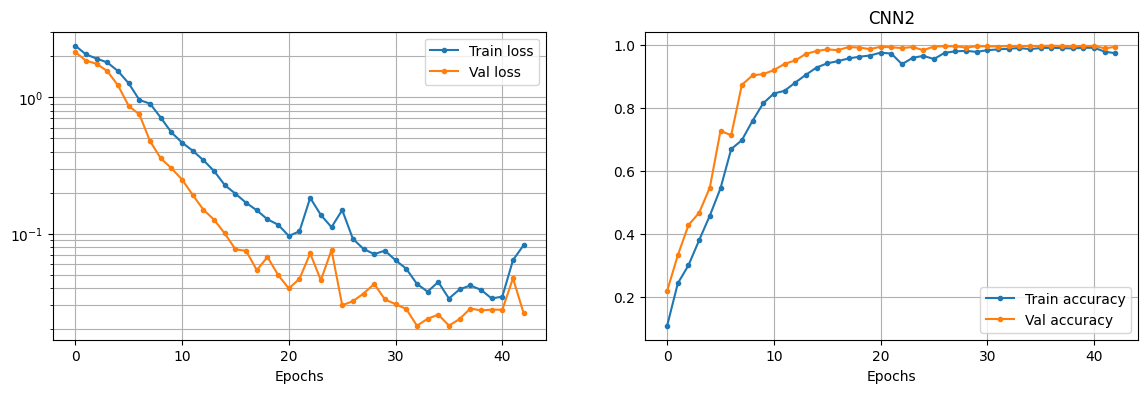

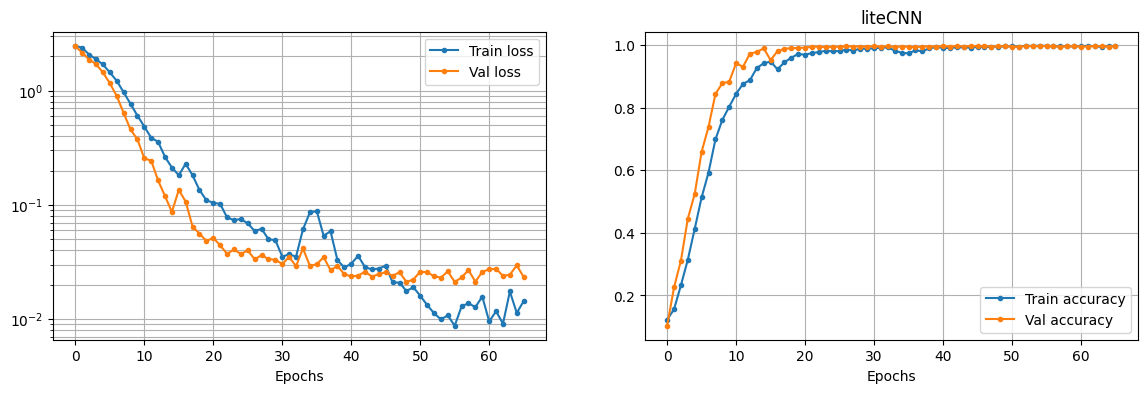

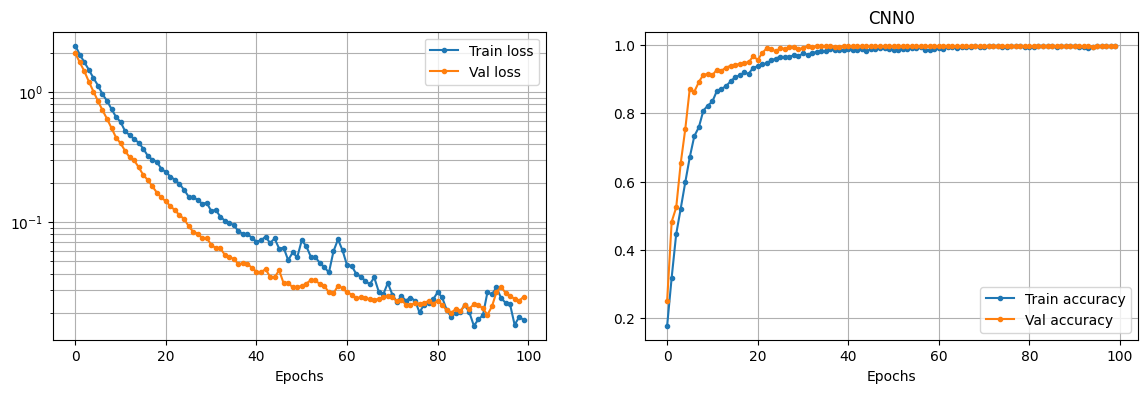

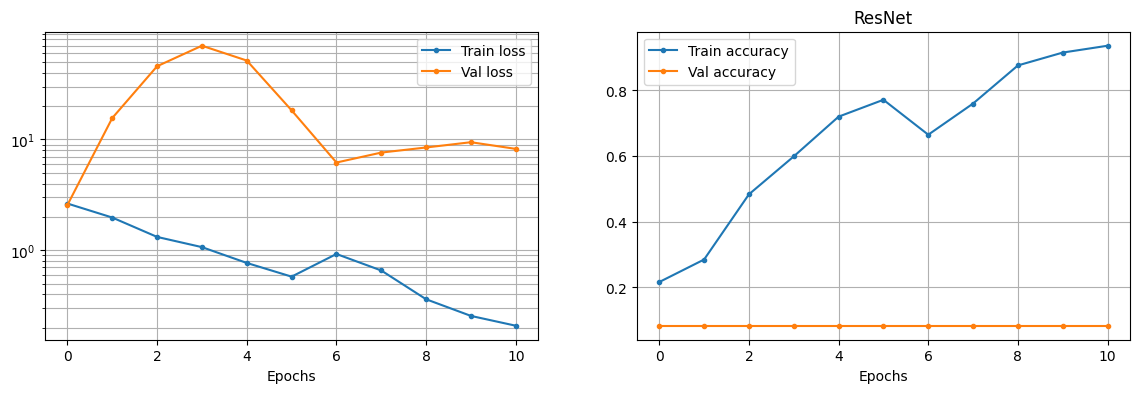

In [27]:
models = [
    get_CNN3(),
    get_CNN2(),
    get_liteCNN(),
    get_CNN0(),
    get_ResNet()
    ]

names = [
    'CNN3',
    'CNN2',
    'liteCNN',
    'CNN0',
    'ResNet'
    ]


for i, model in enumerate(models):
  history = train(model, epochs=100, batch_size=512, lr=0.001, callbacks=[EarlyStopping(patience=10)])
  plots(history, name = names[i])

c:\Users\Luiz\.conda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/100 [00:00<?, ?epoch/s]

 11%|█         | 11/100 [00:36<04:53,  3.30s/epoch, loss=0.0258, accuracy=0.995, val_loss=9.39, val_accuracy=0.0833]


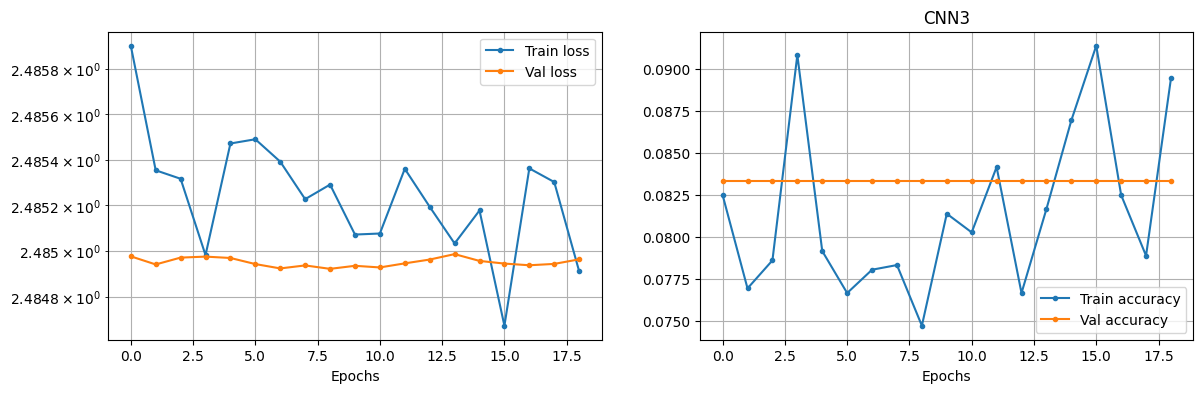

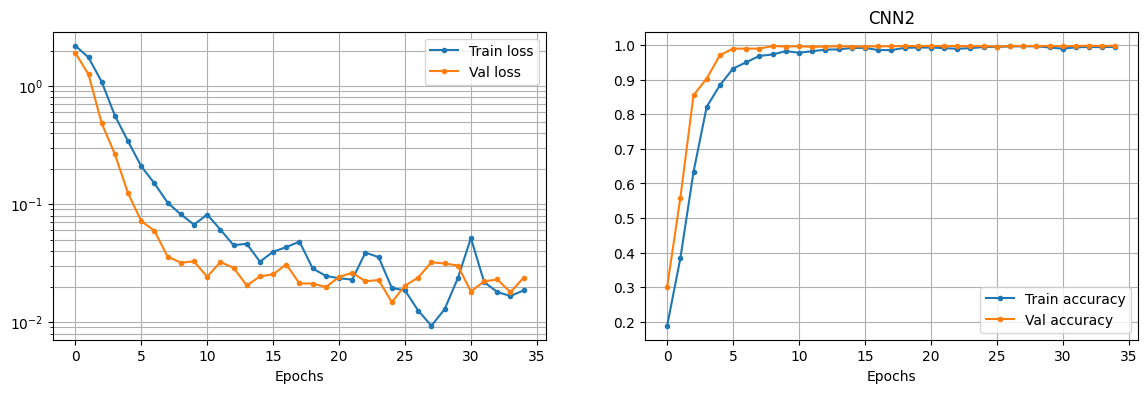

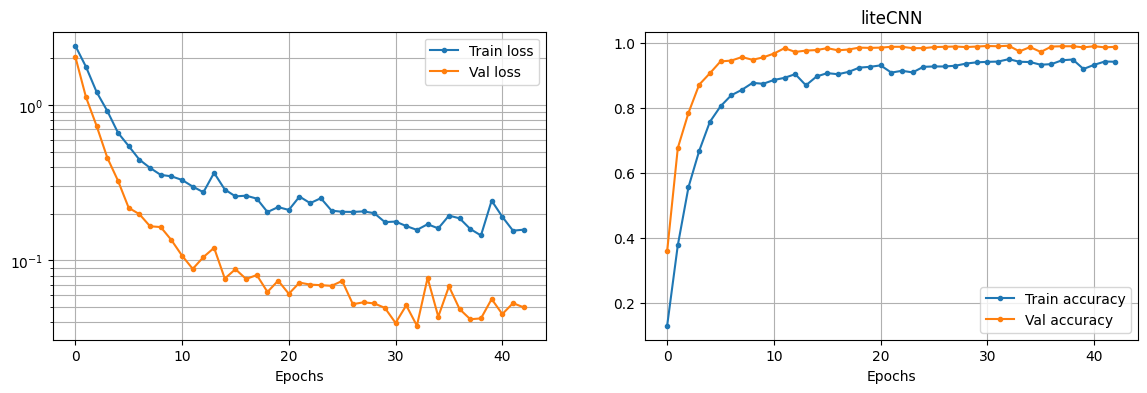

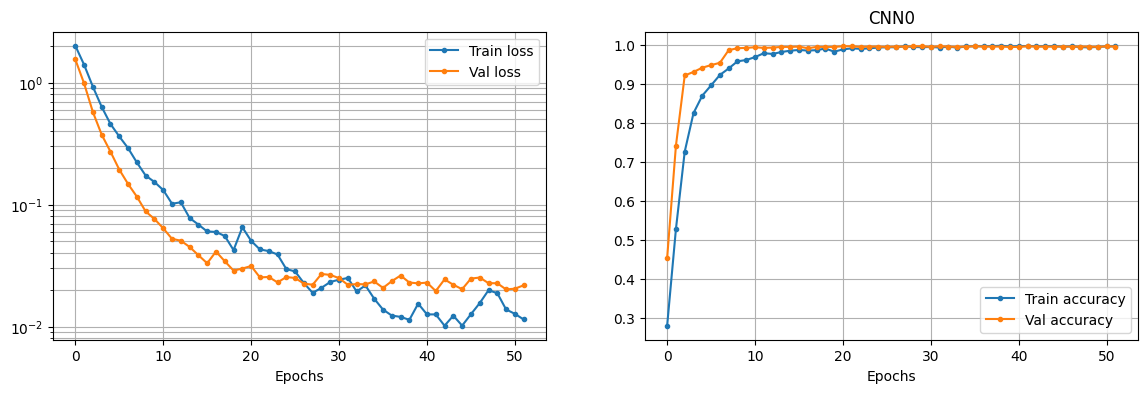

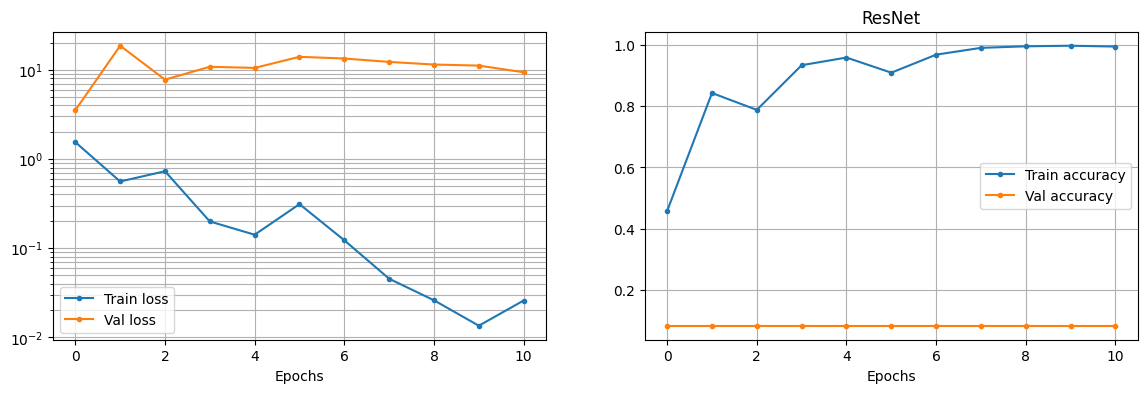

In [23]:
models = [
    get_CNN3(),
    get_CNN2(),
    get_liteCNN(),
    get_CNN0(),
    get_ResNet()
    ]

names = [
    'CNN3',
    'CNN2',
    'liteCNN',
    'CNN0',
    'ResNet'
    ]


for i, model in enumerate(models):
  history = train(model, epochs=100, batch_size=128, lr=0.001, callbacks=[EarlyStopping(patience=10)])
  plots(history, name = names[i])

 27%|██▋       | 27/100 [01:48<04:52,  4.01s/epoch, loss=0.0155, accuracy=0.998, val_loss=0.0281, val_accuracy=0.997]


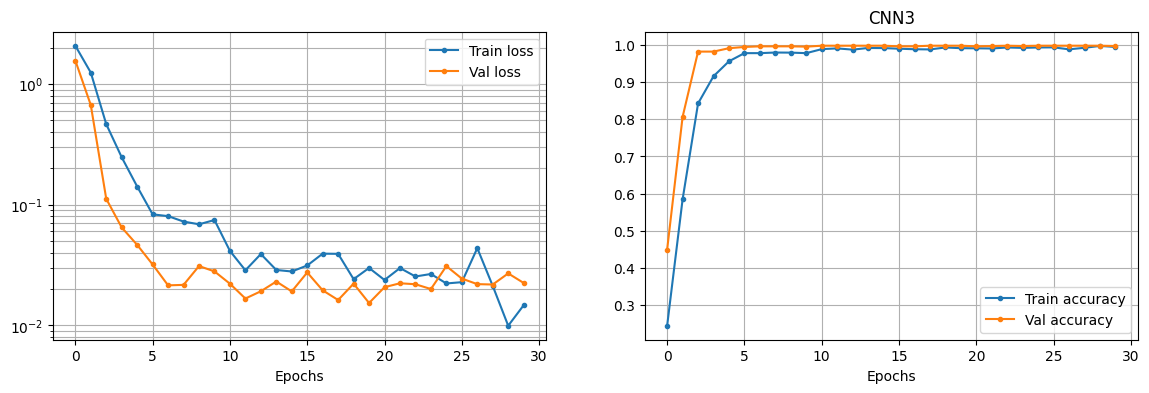

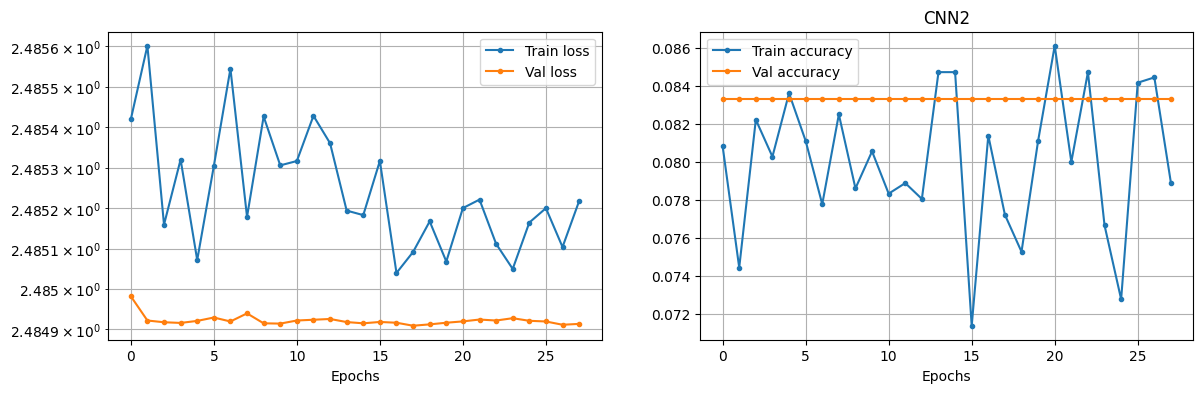

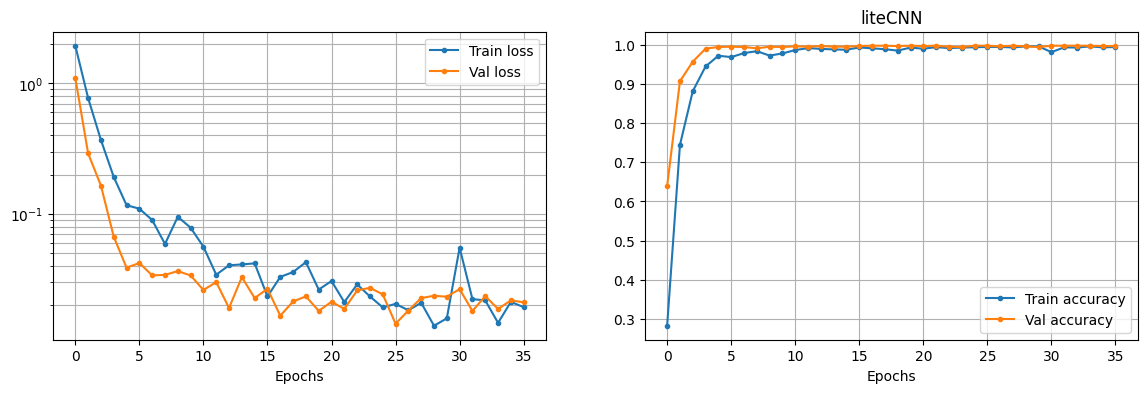

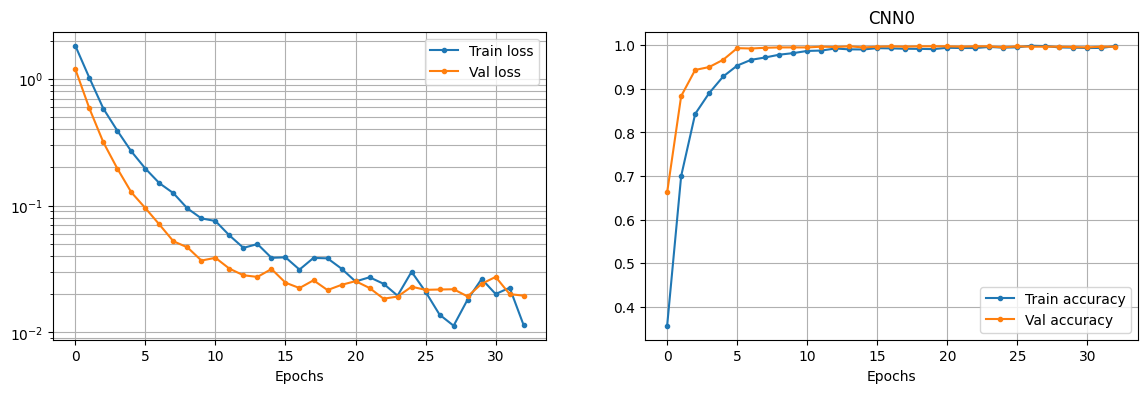

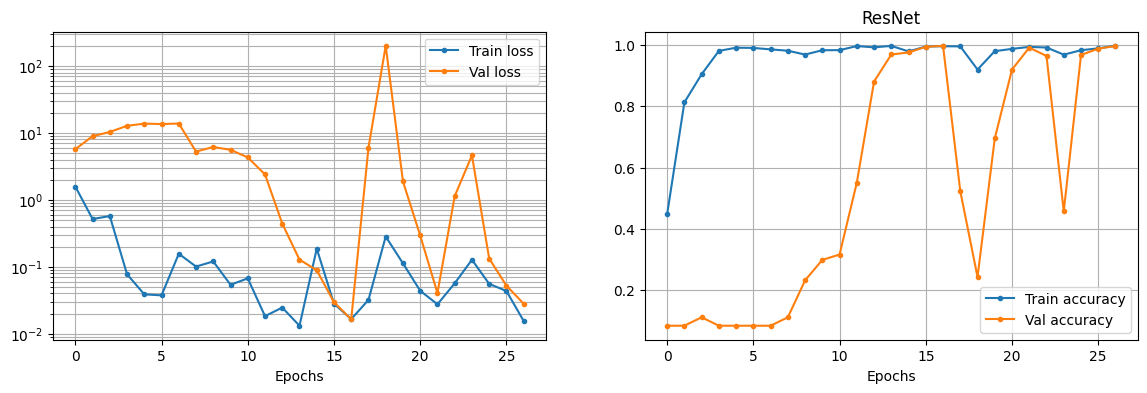

In [24]:
models = [
    get_CNN3(),
    get_CNN2(),
    get_liteCNN(),
    get_CNN0(),
    get_ResNet()
    ]

names = [
    'CNN3',
    'CNN2',
    'liteCNN',
    'CNN0',
    'ResNet'
    ]

for i, model in enumerate(models):
  history = train(model, epochs=100, batch_size=64, lr=0.001, callbacks=[EarlyStopping(patience=10)])
  plots(history, name = names[i])

  0%|          | 0/100 [00:00<?, ?epoch/s]

 31%|███       | 31/100 [02:01<04:31,  3.93s/epoch, loss=0.122, accuracy=0.965, val_loss=5.03, val_accuracy=0.415]   


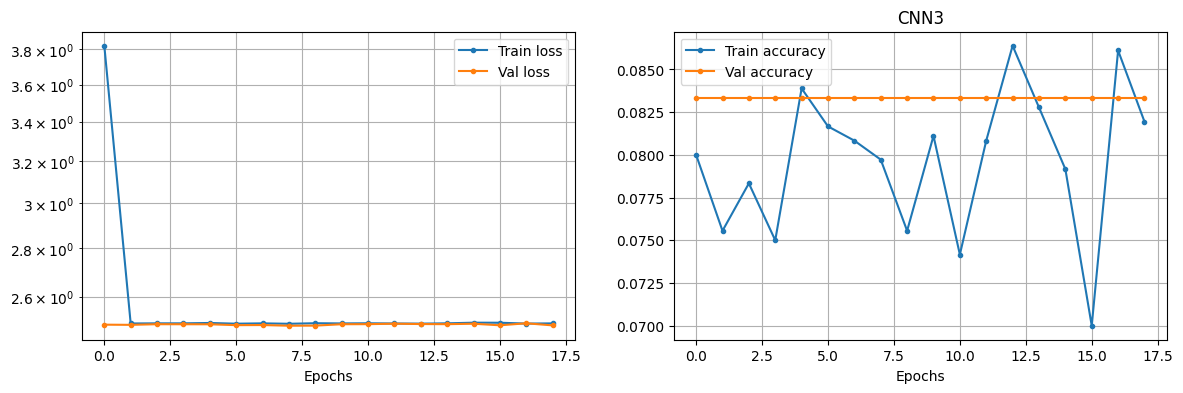

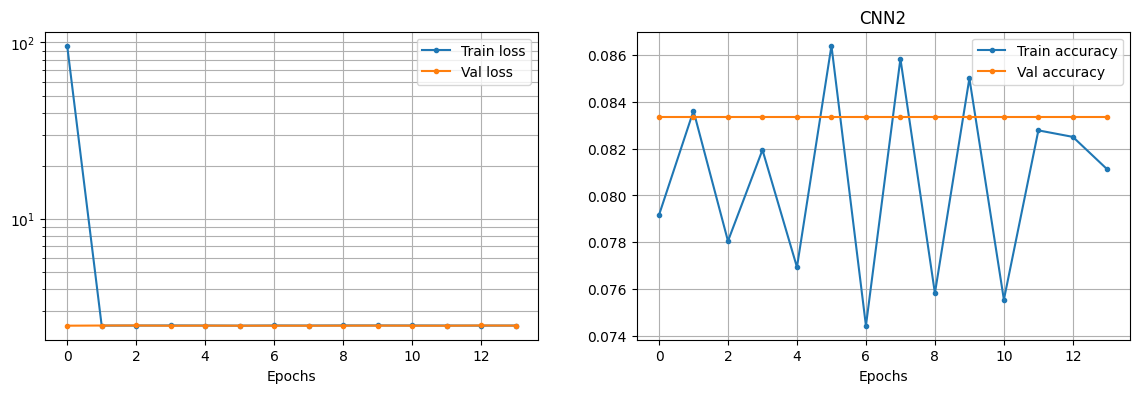

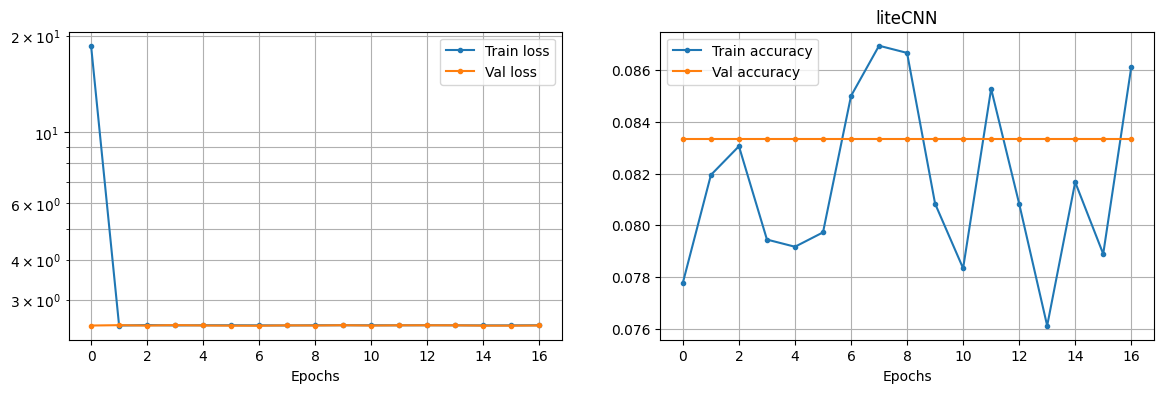

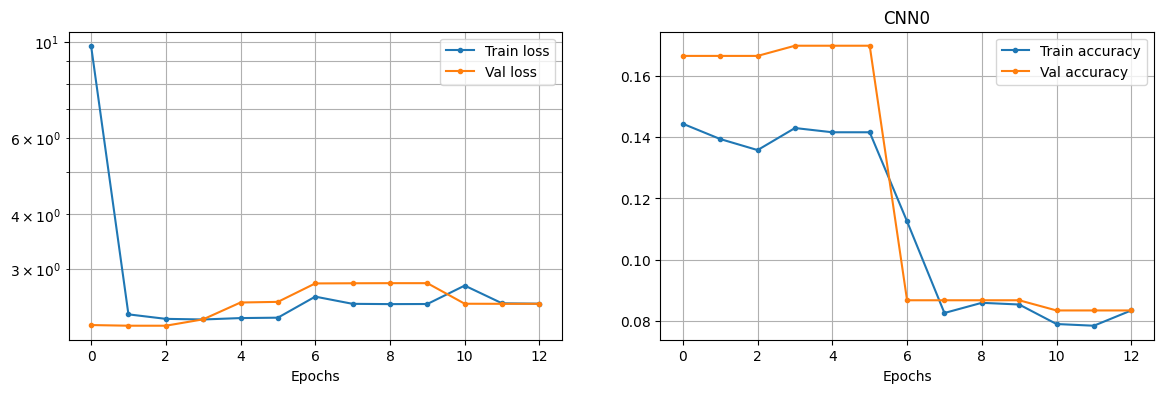

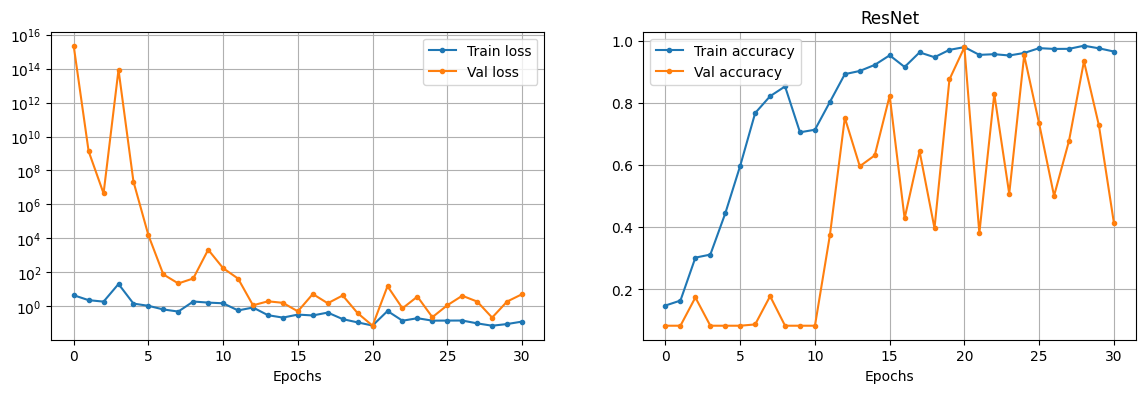

In [25]:
models = [
    get_CNN3(),
    get_CNN2(),
    get_liteCNN(),
    get_CNN0(),
    get_ResNet()
    ]

names = [
    'CNN3',
    'CNN2',
    'liteCNN',
    'CNN0',
    'ResNet'
    ]

for i, model in enumerate(models):
  history = train(model, epochs=100, batch_size=64, lr=0.1, callbacks=[EarlyStopping(patience=10)])
  plots(history, name = names[i])

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/100 [00:00<?, ?epoch/s]

 55%|█████▌    | 55/100 [02:47<02:17,  3.05s/epoch, loss=0.0735, accuracy=0.98, val_loss=1.73, val_accuracy=0.6]     


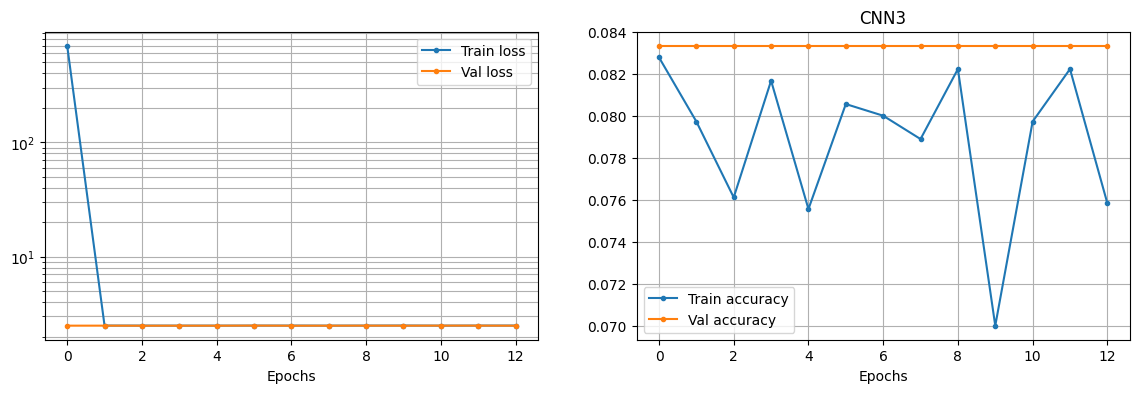

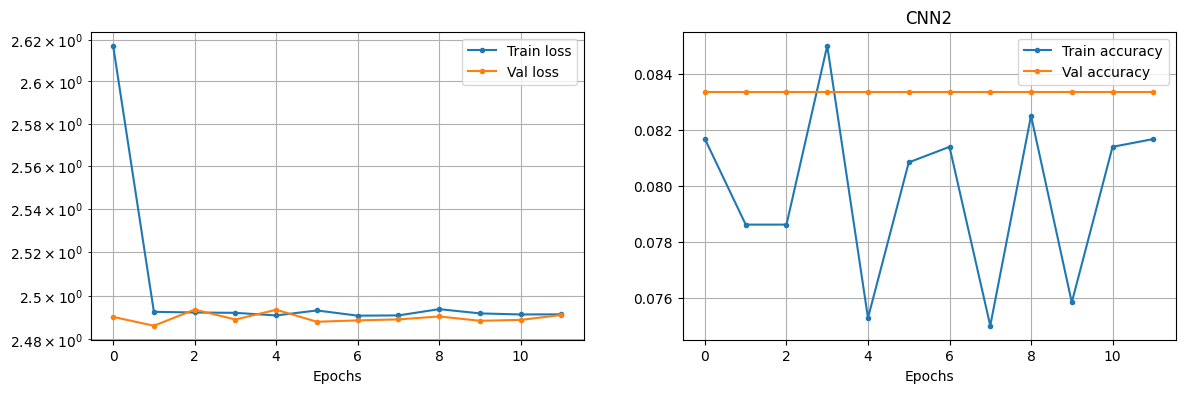

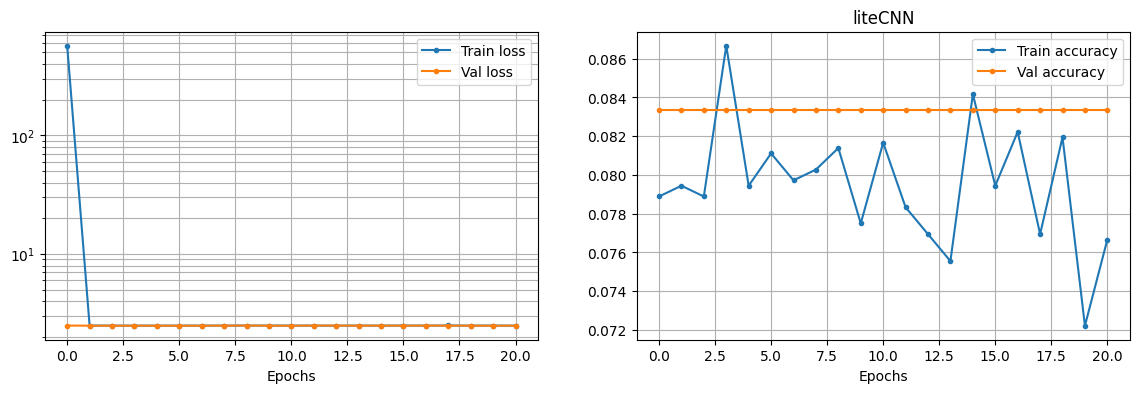

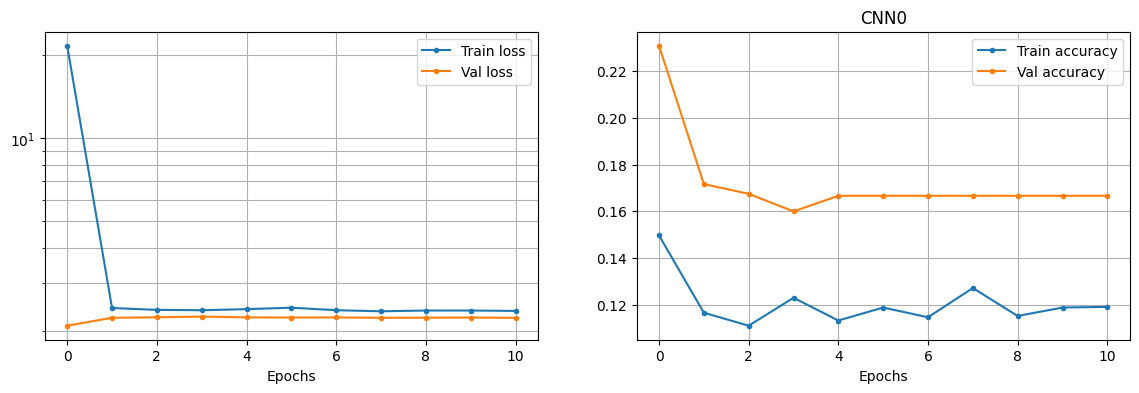

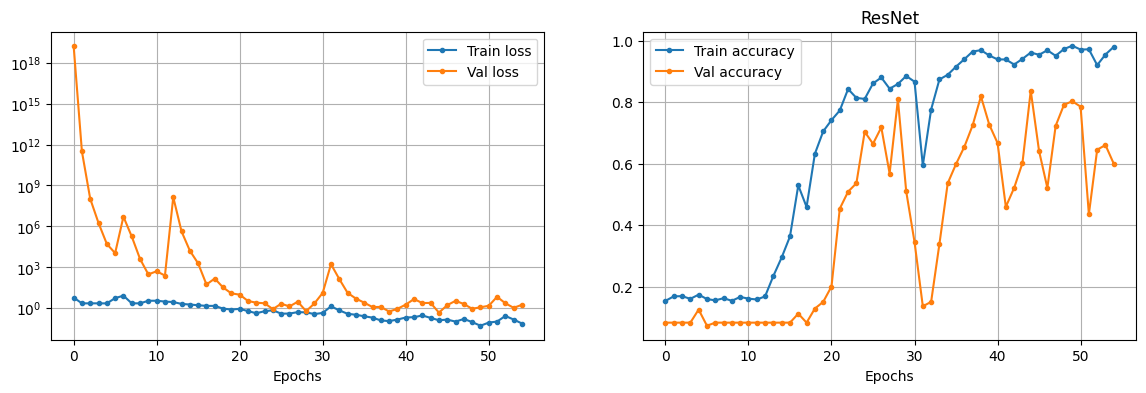

In [26]:
models = [
    get_CNN3(),
    get_CNN2(),
    get_liteCNN(),
    get_CNN0(),
    get_ResNet()
    ]

names = [
    'CNN3',
    'CNN2',
    'liteCNN',
    'CNN0',
    'ResNet'
    ]

for i, model in enumerate(models):
  history = train(model, epochs=100, batch_size=128, lr=0.1, callbacks=[EarlyStopping(patience=10)])
  plots(history, name = names[i])

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/100 [00:00<?, ?epoch/s]

  6%|▌         | 6/100 [00:17<03:52,  2.47s/epoch, loss=1.82, accuracy=0.313, val_loss=5.93e+9, val_accuracy=0.0833] 

KeyboardInterrupt: 

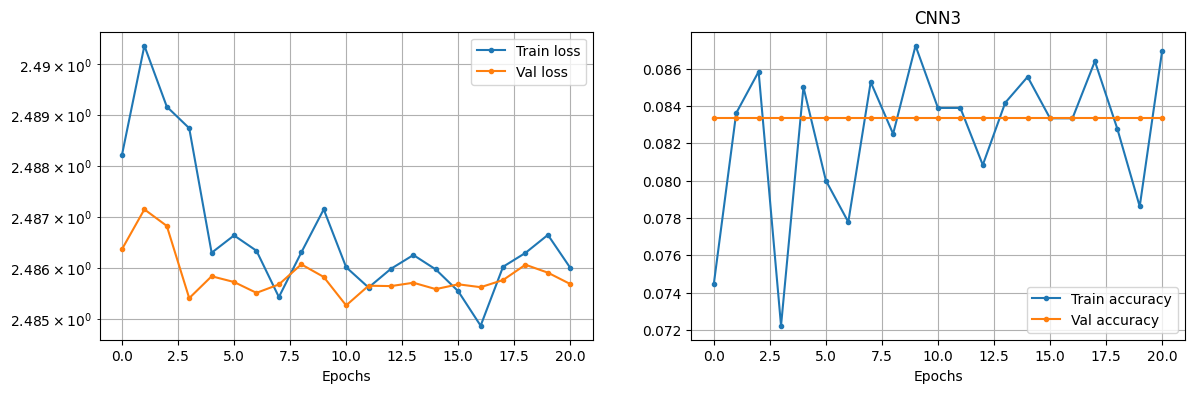

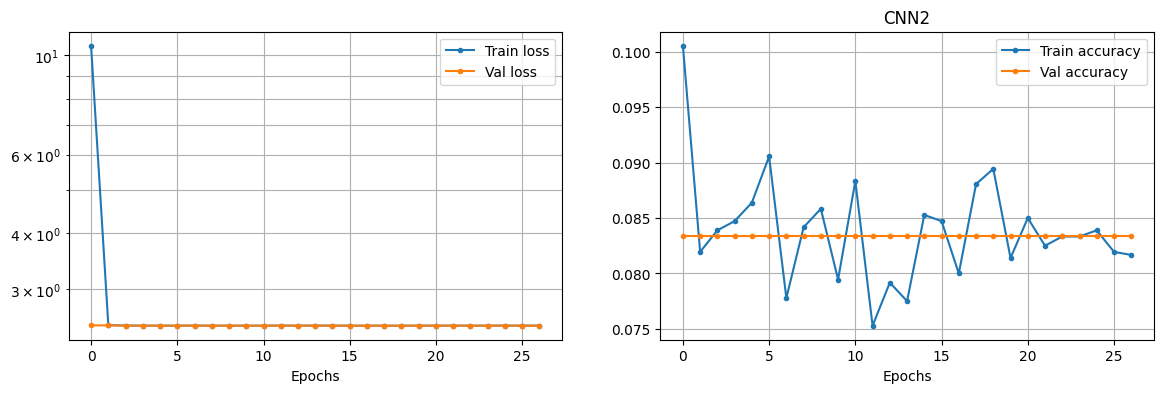

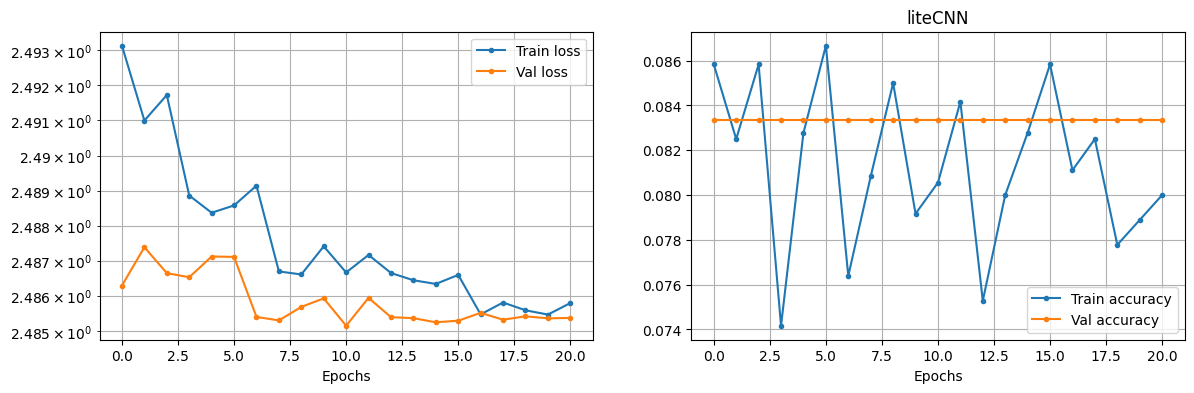

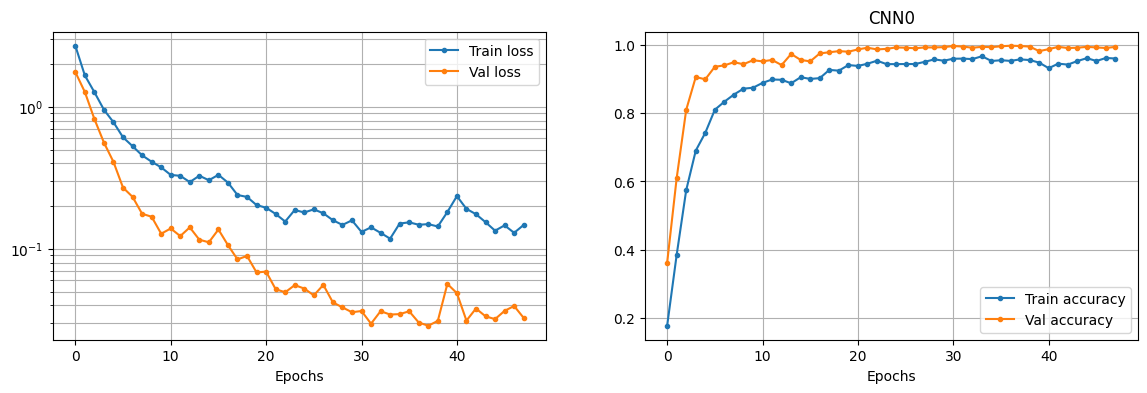

In [28]:
models = [
    get_CNN3(),
    get_CNN2(),
    get_liteCNN(),
    get_CNN0(),
    get_ResNet()
    ]

names = [
    'CNN3',
    'CNN2',
    'liteCNN',
    'CNN0',
    'ResNet'
    ]


for i, model in enumerate(models):
  history = train(model, epochs=100, batch_size=512, lr=0.01, callbacks=[EarlyStopping(patience=10)])
  plots(history, name = names[i])